In [18]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)
from mmfutils.contexts import NoInterrupt
try: from importlib import reload
except ImportError: pass
%pylab inline

<IPython.core.display.Javascript object>

Populating the interactive namespace from numpy and matplotlib


c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Fulde-Ferrell (FF) States

Here we work through some details about the Fulde Ferrell state.  The corresponding code is in the following files:

* [`tf_completion.py`](tf_completion.py)
* [`fulde_ferrell.py`](fulde_ferrell.py)


The first file contains all the integrals:

* `n_p_integrand`:

  $$
    \newcommand{\E}{\mathcal{E}}\newcommand{\e}{\epsilon}
    \int \frac{\d^d{k}}{(2\pi)^d}\; \left(1 - \frac{\e_+}{E}\bigl(f_\beta(\omega_-) - f_\beta(\omega_+)\bigr)\right)
  $$

The idea of the FF state is that the gap has a form $\Delta(z) = e^{\I q z}\Delta$.  By rotating the basis, we can absorb the $q$ into the kinetic energy:

$$
  \mat{M} = \begin{pmatrix}
    \frac{\hbar^2[(k_z-q)^2 + k_\perp^2]}{2m_a} - \mu_a & \Delta\\
    \Delta & -\left(\frac{\hbar^2[(k_z+q)^2 + k_\perp^2]}{2m_b} - \mu_b\right)
  \end{pmatrix}.
$$

The eigenvalues $\omega_{\pm}$ are zero when:

$$
  m_a = m_b = m, \qquad k^2 = k_z^2 + k_\perp^2, \qquad
  \e_{\pm} = \frac{\e_a \pm \e_b}{2}, \\
  \omega_{\pm} = \e_- \pm \sqrt{\e_+^2 + \abs{\Delta}^2} = 0 \quad 
  \Rightarrow \quad \e_{-}^2 = \e_+^2 + \abs{\Delta}^2,\\
  \e_+ = \frac{\hbar^2k^2}{2m} - \overbrace{\left(\mu_+ - \frac{\hbar^2q^2}{2m}\right)}^{\mu_q},\qquad
  \e_- = \frac{qk_z\hbar^2}{m} - \mu_-,\\
  k_\perp^2 = -k_z^2 + \frac{2m}{\hbar^2}\left(\mu_q \pm \sqrt{\left(\frac{qk_z\hbar^2}{m} - \mu_-\right)^2 - \abs{\Delta}^2}\right).
$$

All the real parts of this equation can be used as `points` for accurate integration.

## Momentum Integrals

To regulate the theory, we will need to compute integrals up to a cubic cutoff $k < k_c$.  We shall assume in the code that $k_c$ is much larger than any of these `points`.

## Gap Equation

Our code takes as inputs: ($\mu_+$, $\mu_-$, $q$, $\Delta$, $T$).  From these, we can compute $\mat{M}$ and integrate all of the states up to $k_c$ or beyond.  The gap equation has the form:

$$
  \tilde{C} = \frac{-\nu_c}{\Delta} + \Lambda_c = \frac{m}{4\pi \hbar^2 a_s}\\
  = \lim_{k_c\rightarrow \infty}
  \left(
    - \int_{k<k_c}\frac{\d^d{k}}{(2\pi)^d}\;
    \frac{f_\beta(\omega_-) - f_\beta(\omega_+)}{2\sqrt{\e_+^2 + \Delta^2}}
    +
    \overbrace{\frac{1}{2} \int_{k<k_c}\frac{\d^d{k}}{(2\pi)^d}\;\frac{1}{\e_+ + \I 0^+}}^{\Lambda_c}
  \right)
$$

*Note: Computing this is a bit tricky. Numerically one cannot easily integrated the entire expression because of the poles at $\epsilon_+ = 0$, however, the second integral can be computed analytically for finite $k_c$.  Thus, the computation of this term can proceed as follows, which is done in the function `compute_C()`:*

$$
  \tilde{C} = 
    - \int_{k<k_c}\frac{\d^d{k}}{(2\pi)^d}\;
    \frac{f_\beta(\omega_-) - f_\beta(\omega_+)}{2\sqrt{\e_+^2 + \Delta^2}}
  + \Lambda_c(\mu_q)
  +  \int_{k\geq k_c}\frac{\d^d{k}}{(2\pi)^d}\;\left(
    -\frac{f_\beta(\omega_-) - f_\beta(\omega_+)}{2\sqrt{\e_+^2 + \Delta^2}}
    + \frac{1}{2\e_+}
  \right).
$$

A physical theory holds $\tilde{C}$ fixed (or as a predefined function of densities).  Thus, this equation must be solved to figure out $\Delta$.  In the unitary limit, $\tilde{C} = 0$.  Solving this equation is tricky, because the rhs might not even be monotonic.  There might also only be the single solution $\Delta = 0$.



As a result, one can construct states by fixing $\Delta$ and then computing the interaction at which that state is self-consistent.

In [19]:
import numpy as np
import tf_completion as tf;reload(tf)

np.random.seed(1)
m, hbar, kF = 1 + np.random.random(3)
eF = (hbar*kF)**2/2/m
nF = kF**3/3/np.pi**2
mu = 0.59060550703283853378393810185221521748413488992993*eF
delta = 0.68640205206984016444108204356564421137062514068346*eF

dmu = 0.5*delta
args0 = dict(mu_a=mu+dmu, mu_b=mu-dmu, delta=delta, m_a=m, m_b=m, 
             hbar=hbar, d=3, T=0.0)

# Make a FF state with q
k_c = 10*kF
q = -0.8*kF
args = dict(args0, q=q, k_c=k_c)
tf.compute_C(**args), tf.integrate_q(tf.n_m_integrand, **args)


c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\scipy\integrate\quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\scipy\integrate\quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gai

(0.02212840044381468+/-3.7976093104890745e-08,
 0.010519068211916564+/-6.219387032810331e-08)

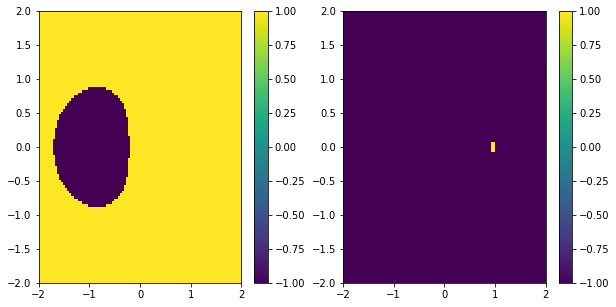

In [20]:
from mmfutils.plot import imcontourf
kz = np.linspace(-2, 2, 100)[:, None]
kp = np.linspace(-2, 2, 100)[None, :]
e = hbar**2/2/m
e_a = e*((kz-q)**2 + kp**2) - args['mu_a']
e_b = e*((kz+q)**2 + kp**2) - args['mu_b']
e_p, e_m = (e_a + e_b)/2, (e_a - e_b)/2
E = np.sqrt(e_p**2+abs(delta)**2)
w_p, w_m = e_m + E, e_m - E
plt.figure(figsize=(10,5))
plt.subplot(121)
imcontourf(kz, kp, np.sign(w_p), vmin=-1, vmax=1);plt.colorbar()
plt.subplot(122)
imcontourf(kz, kp, np.sign(w_m), vmin=-1, vmax=1);plt.colorbar()

Text(0, 0.5, 'n')

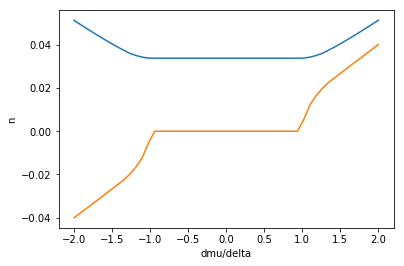

In [21]:
ss = np.linspace(-2, 2, 50)
res = []
for s in ss:
    dmu = s*delta
    mu_a, mu_b = mu + dmu, mu - dmu
    args = dict(args0, mu_a=mu_a, mu_b=mu_b)
    n_p = tf.integrate(tf.n_p_integrand, **args)
    n_m = tf.integrate(tf.n_m_integrand, **args)
    res.append((n_p.n, n_m.n))

res = np.asarray(res)
plt.plot(ss, res);plt.xlabel('dmu/delta');plt.ylabel('n')

In [24]:
from scipy.optimize import brentq
def get_delta(dmu=0, q=0, debug=False, **kw):
    def f(delta):        
        args = dict(args0)
        
        args['mu_a'], args['mu_b'] = mu + dmu, mu - dmu
        args.update(kw)        
        args['delta'] = delta
        C = tf.compute_C(q=q, **args)
        return C.n
    if debug:
        return f
    return brentq(f, 0.5, 1.0)

get_delta(dmu=0.5*delta, q=0), delta

(0.7169552805432827, 0.7169552803334721)

c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\scipy\integrate\quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


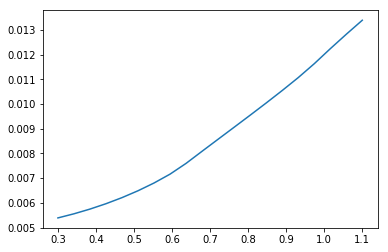

In [25]:
f = get_delta(dmu=0.2*delta, q=0.5, debug=True)

ss = np.linspace(0.3, 1.1, 20)
plt.plot(ss, [f(s) for s in ss])


E:\Projects\Physics\quantum-fermion-theories\quantum-turbulence\tf_completion.py:310: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  
E:\Projects\Physics\quantum-fermion-theories\quantum-turbulence\tf_completion.py:311: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling t

E:\Projects\Physics\quantum-fermion-theories\quantum-turbulence\tf_completion.py:310: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  
E:\Projects\Physics\quantum-fermion-theories\quantum-turbulence\tf_completion.py:311: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling t

Text(0, 0.5, 'C(0)')

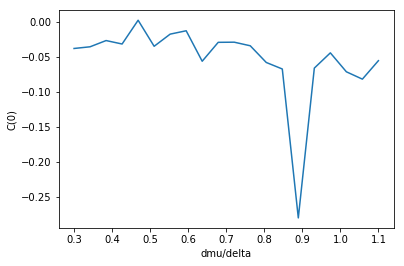

In [26]:
from scipy.optimize import brentq
def get_delta(dmu=0, q=0, debug=False, **kw):
    def f(delta):         
        args = dict(args0)
        args['mu_a'], args['mu_b'] = mu + dmu, mu - dmu
        args.update(kw)        
        args['delta'] = delta
        C = tf.integrate(tf.C_integrand, k_c=10.0, **args)
        return C.n
    if debug:
        return f
    return brentq(f, 0.0, 1.0)

ss = np.linspace(0.3, 1.1, 20)
res = []
for s in ss:
    f = get_delta(dmu=s*delta, debug=True)
    res.append(f(0.001))
plt.plot(ss, res);plt.xlabel('dmu/delta');plt.ylabel('C(0)')

Text(0, 0.5, 'C(0)')

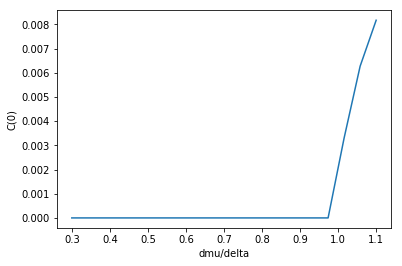

In [31]:
from scipy.optimize import brentq
def get_delta(dmu=0, q=0, debug=False, **kw):
    def f(delta):        
        args = dict(args0)
 
        args['mu_a'], args['mu_b'] = mu + dmu, mu - dmu
        args.update(kw)        
        args['delta'] = delta
        C = tf.compute_C(**args)
        return C.n
    if debug:
        return f
    return brentq(f, 0.0, 1.0)

ss = np.linspace(0.3, 1.1, 20)
res = []
for s in ss:
    f = get_delta(dmu=s*delta, debug=True)
    res.append(f(delta))
plt.plot(ss, res);plt.xlabel('dmu/delta');plt.ylabel('C(0)')

Text(0, 0.5, 'C')

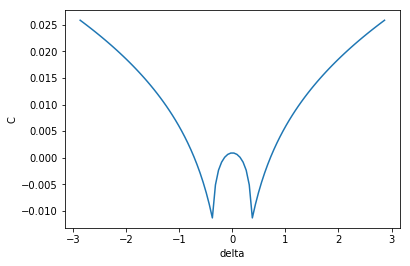

In [34]:
ss = np.linspace(-4, 4, 100)
res = []
for s in ss:
    args = dict(args0,delta=s*delta)
    C = tf.compute_C(**args)
    res.append(C.n)

res = np.asarray(res)
plt.plot(ss*delta, res);plt.xlabel('delta');plt.ylabel('C')

# To Do

* Check speed of `dblquad` vs nested calls to `quad`.